# Whats your name?

*von Raphael Koller und Lena Willisits*

## Höchstes Vorkommen einzelner Vornamen bei Lebendgeborenen

Das Ziel dieses Projekts ist es, die beliebtesten Vornamen bei Lebendgeborenen bzw. auch deren Vorkommen in ausgewählten geografischen Zonen in Österreich zu identifizieren. Hierbei wird auch der höchste relative Anteil an gleich benannten Lebendgeborenen unter Berücksichtigung der Einwohnerzahl berechnet. Das Projekt wird von Raphael Koller und Lena Willisits durchgeführt.

### Datenquellen

Die geplanten Datenquellen für dieses Projekt sind:

- [Statistik Austria: Vornamen nach Geburtsjahr, Geschlecht und politischem Bezirk ab 2010](https://www.data.gv.at/katalog/de/dataset/stat_vornamen#resources)
- [Statistik Austria: Bevölkerung seit 1869 für Gemeinden, Politische Bezirke und Bundesland](https://www.data.gv.at/katalog/de/dataset/stat_bevolkerung-seit-1869-fur-politische-bezirke-und-bundesland)
    - [Liste der Bezirke und Statutarstädte in Österreich](https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Statutarst%C3%A4dte_in_%C3%96sterreich)

### Datenspeicher

Als Datenbank (NoSQL) für dieses Projekt wird Elasticsearch verwendet.

### Geplanter Ablauf

1. Ein Jupyter Notebook für das Projekt anlegen.
2. Infrastruktur-Aspekte des Projekts planen und umsetzen.
    - Installation eines virtuellen Servers in der Cloud.
    - Einrichten eines Github Repositorys.
3. Docker-Container einrichten, um Elasticsearch DB zu starten (mittels `docker-compose.yml`).
4. Index in Elasticsearch anlegen.
5. Verbindung zur Datenbank über Jupyter Notebook aufbauen.
6. Index mit CSV-Inhalten befüllen.
    - Säubern der Daten.
7. Abfragen formulieren, um das Projektthema zu erarbeiten.
8. Elasticsearch DSL für die Suche und Pandas für die Visualisierung und Daten-Erkundung nutzen.
9. Markdown-Notizen hinzufügen, um das Projekt zu beschreiben.
10. Das Projekt finalisieren.
11. Das Notebook testen (vom Anfang bis zum Ende ausführen).
12. Überprüfen, ob alle Kriterien laut Projektspezifikation erfüllt sind.

### Erwartetes Ergebnis

Das erwartete Ergebnis dieses Projekts ist ein gut strukturiertes Jupyter Notebook, das alle notwendigen Informationen enthält, um die Ergebnisse zu reproduzieren. Zudem sollen verschiedene Methoden der Big Data erkundet und Tools der Data Science angewendet werden. Schließlich soll eine spannende Geschichte mit Hilfe der aufbereiteten Daten erzählt werden.

### Python Pakete importieren bzw. ggf. installieren

In diesem Code-Abschnitt werden verschiedene Python-Module importiert, die für die Verarbeitung von Elasticsearch-Daten nützlich und notwendig sind. Wenn alle Module bereits installiert sind, wird der Code ohne Probleme ausgeführt. Wenn jedoch eines oder mehrere Module fehlen, versucht der Code, die fehlenden Pakete zu installieren und anschließend die erforderlichen Module zu importieren. Dies ist eine nützliche Funktion, da es dem Benutzer ermöglicht, auf eine einfache Weise alle erforderlichen Abhängigkeiten für das Skript zu installieren.

In [12]:
try:
    from elasticsearch import Elasticsearch, helpers
    from elasticsearch.helpers import bulk, scan
    from elasticsearch_dsl import Search
    import pandas as pd
    import json
    import matplotlib.pyplot as plt
    import numpy as np
    from functools import reduce
except ImportError as e:
    print(f"Missing package: {e.name}")
    print("Installing missing package...")
    %pip install {e.name}

### Virtuelle Server bereitgestellt und Elasticsearch mittels docker-compose.yml gestartet

In diesem Abschnitt geht es darum, wie man auf einem virtuelle Server in der Cloud eine Elasticsearch Node Instanz mit Hilfe von Docker Compose konfiguriert. Nachfolgend die Konfigurationsdatei welche am Server in der Cloud im Hintergrund (-detach) gestartet wurde.

##### Folgende docker-compose.yml wurde verwendet:
```bash
version: '3.3'

services:
  bdinf_final_project:
    image: docker.elastic.co/elasticsearch/elasticsearch:8.7.1
    container_name: elasticsearch
    environment:
      - ELASTIC_PASSWORD=iA7LwG44T2Dq5NXd9D7C
      - xpack.security.enabled=false
      - discovery.type=single-node
    ports:
      - 9200:9200
    restart: always
```

### Zum Elasticsearch Node mittels Basic Authentication verbinden

Dieser Code-Abschnitt zeigt, wie man sich mit einem privaten Elasticsearch-Node verbindet, welche mit einer Basic Authentication geschützt ist. Dazu wird eine Verbindung zu der Elasticsearch-URL mit dem Benutzernamen "elastic" und dem Passwort "iA7LwG44T2Dq5NXd9D7C" hergestellt. Im Live Betrieb sollte man eine öffentlich erreichbare Node immer mittels https und Zertifikaten und die Anmeldung mittels Hashes absichern.

Anschließend wird getestet, ob die Verbindung erfolgreich hergestellt werden konnte, indem der Befehl "es.info()" ausgeführt wird. Wenn die Verbindung erfolgreich ist, wird die Meldung "Connected to Elasticsearch" ausgegeben, andernfalls "Could not connect to Elasticsearch".

Die Ping-Funktion wird ebenfalls verwendet, um die Verbindung erneut zu testen. Wenn das Ping-Kommando erfolgreich ist, wird erneut die Meldung "Connected to Elasticsearch" ausgegeben. Andernfalls wird die Meldung "Could not connect to Elasticsearch" ausgegeben.

In [82]:
# Connect to a privately hosted Elasticsearch node
es = Elasticsearch(
    "http://81.173.84.159:9200",
    basic_auth=("elastic", "iA7LwG44T2Dq5NXd9D7C")
)

In [3]:
# Test if the Elasticsearch connection is valid
try:
    print(es.info())
except:
    print("Wait until Elasticsearch is fully started")

{'name': '7f76c63ac5bd', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'CrGZljlSQ0CVFbvNI-SiZg', 'version': {'number': '8.7.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'f229ed3f893a515d590d0f39b05f68913e2d9b53', 'build_date': '2023-04-27T04:33:42.127815583Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [4]:
# Use the ping command to test again
if es.ping():
    print("Connected to Elasticsearch")
else:
    print("Could not connect to Elasticsearch")

Connected to Elasticsearch


### Index "idx1" erstellen

Nun wird ein neuer Elasticsearch-Index mit dem Namen "idx1" erstellt. Dazu wird der Indexname in einer Variablen mit dem Namen "es_index" gespeichert.

Anschließend wird die Methode "es.indices.create()" verwendet, um den Index in Elasticsearch zu erstellen.

In [13]:
# Assign index name to a variable
es_index = 'idx1'

In [ ]:
# Create index in Elasticsearch
es.indices.create(index=es_index)

### Daten von CSV Dateien einliesen und in den Elasticsearch Index "idx1" importieren

Nach der Erstellung des Indexes werden Daten aus CSV-Dateien eingelesen und in den Elasticsearch-Index "idx1" importiert. Dazu werden mehrere Funktionen definiert, die den Code lesbarer und wartbarer machen sollen.

Die Funktion "read_csv_file(file_path)" liest eine CSV-Datei und gibt ein pandas DataFrame zurück. Die Funktion "create_es_action(row, es_index)" erstellt eine Elasticsearch-Aktion aus einer Zeile des DataFrames und dem Indexnamen. Schließlich verwendet die Funktion "import_csv_to_es(es, index_name, file_path)" diese beiden Funktionen, um eine CSV-Datei in den Elasticsearch-Index zu importieren.

Zu guter Letzt wird die Funktion "import_csv_to_es(es, index_name, file_path)" verwendet, um Daten aus zwei CSV-Dateien in den Elasticsearch-Index "idx1" zu importieren. Die CSV-Dateien befinden sich im Ordner "Data" und werden nacheinander verarbeitet. Während des Imports wird eine Meldung ausgegeben, die den aktuellen Verarbeitungsschritt anzeigt. Wenn der Importvorgang erfolgreich abgeschlossen ist, wird eine Bestätigungsmeldung ausgegeben.

In [11]:
# Functions for clean code
def read_csv_file(file_path):
    return pd.read_csv(file_path)

def create_es_action(row, es_index):
    return {
        '_index': es_index,
        '_source': row.to_dict()
    }

def import_csv_to_es(es, index_name, file_path):
    df = read_csv_file(file_path)
    actions = (create_es_action(row, index_name) for _, row in df.iterrows())
    bulk(es, actions)

In [197]:
# Path to .csv data files
file_paths = ["Data/OGD_f0743_VZ_HIS_GEM_2.csv", "Data/OGDEXT_VORNAMEN_1.csv"]

In [198]:
# Import .csv files into Elasticsearch
for file_path in file_paths:
    print(f"Importing {file_path}...")
    import_csv_to_es(es, es_index, file_path)
    print(f"{file_path} imported successfully.")

Importing Data/OGD_f0743_VZ_HIS_GEM_2.csv...
Data/OGD_f0743_VZ_HIS_GEM_2.csv imported successfully.
Importing Data/OGDEXT_VORNAMEN_1.csv...
Data/OGDEXT_VORNAMEN_1.csv imported successfully.


### Dokumente vom Index in Elasticsearch auslesen

Hier wird beschrieben, wie Dokumente aus dem Elasticsearch-Index "idx1" ausgelesen und als JSON-Objekte ausgegeben werden. Der Code verwendet dazu die Methode "es.search()" und gibt das Ergebnis als JSON-Objekte mithilfe der "json.dumps()" Funktion aus.

In [200]:
# Initial read of the imported .csv from Elasticsearch - output in JSON
res = es.search(index="idx1", query={"match_all": {}}, size=5)
print(json.dumps(res['hits']['hits'], indent=2))

[
  {
    "_index": "idx1",
    "_id": "52Jm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 201,
      "C-GESCHLECHT-0": 1,
      "F-VORNAME": "Thibault",
      "F-VORNAME_NORMALISIERT": "Thibault",
      "F-ANZAHL_LGEB": 1
    }
  },
  {
    "_index": "idx1",
    "_id": "6GJm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 201,
      "C-GESCHLECHT-0": 1,
      "F-VORNAME": "Thomas",
      "F-VORNAME_NORMALISIERT": "Thomas",
      "F-ANZAHL_LGEB": 5
    }
  },
  {
    "_index": "idx1",
    "_id": "6WJm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 201,
      "C-GESCHLECHT-0": 1,
      "F-VORNAME": "Till",
      "F-VORNAME_NORMALISIERT": "Til",
      "F-ANZAHL_LGEB": 1
    }
  },
  {
    "_index": "idx1",
    "_id": "6mJm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 20

### Definieren einer Funktion, die eine Suchanfrage auf Elasticsearch ausführt und die Ergebnisse als Pandas DataFrame zurückgibt

In diesem Code-Abschnitt wird eine Funktion definiert, die eine Suchanfrage auf Elasticsearch ausführt und die Ergebnisse als Pandas DataFrame zurückgibt. Die Funktion heißt "es_to_dataframe(es, index, query, source_fields=None)" und hat vier Parameter:

    "es": Der Elasticsearch-Client, der für die Ausführung der Suchanfrage verwendet wird.
    "index": Der Name des Elasticsearch-Index, auf den die Suchanfrage angewendet wird.
    "query": Die Suchanfrage, die auf Elasticsearch ausgeführt wird.
    "source_fields": Eine optionale Liste von Feldern, die aus der Suchanfrage zurückgegeben werden sollen.

In der Funktion wird die Methode "scan()" von Elasticsearch verwendet, um die Suchanfrage auszuführen. Die Methode "scan()" gibt eine Generatorfunktion zurück, die die Ergebnisse der Suchanfrage Zeile für Zeile zurückgibt. Die Daten werden dann aus den Dokumenten extrahiert und in eine Liste von Python-Dictionaries umgewandelt.

Schließlich wird die Liste von Dictionaries in ein Pandas DataFrame umgewandelt und zurückgegeben. Dies ermöglicht es dem Benutzer, die Ergebnisse der Elasticsearch-Suchanfrage in einer tabellarischen Form anzuzeigen und weiter zu verarbeiten.

In [15]:
# Functions for clean code
def es_to_dataframe(es, index, query, source_fields=None):
    scanned_data = scan(es, query=query, index=index, _source=source_fields)
    data = [document['_source'] for document in scanned_data]
    return pd.DataFrame(data)

### Ausführen auf Aufbereitung der ersten Suchabfrage - Geschlechterverteilung in 2011

In der ersten Aufbereitung der Daten wird eine Suchabfrage auf Elasticsearch ausgeführt, um die Geschlechterverteilung im Jahr 2011 zu ermitteln.

Zunächst wird eine Elasticsearch Suchanfrage definiert, die darauf abzielt, Dokumente zu finden, bei denen das Feld "C-JAHR-0" den Wert "2011" hat. Dann wird eine Liste von Feldern definiert, die aus den Suchergebnissen abgerufen werden sollen.

Mithilfe der zuvor definierten Funktion "es_to_dataframe(es, index, query, source_fields=None)" wird die Suchanfrage auf Elasticsearch ausgeführt und das Ergebnis als Pandas DataFrame in der Variablen "df1" gespeichert.

Die Funktion "value_counts()" wird auf das "C-GESCHLECHT-0"-Feld des DataFrames "df1" angewendet, um die Anzahl der Männern und Frauen im Jahr 2011 zu zählen. Das Ergebnis wird in der Variablen "gender_counts" gespeichert und ausgegeben.

Schließlich wird die Geschlechterverteilung in Form eines Tortendiagramms dargestellt, wenn Daten verfügbar sind. Wenn keine Daten gefunden wurden, wird eine Meldung ausgegeben.

In [84]:
# Elasticsearch DSL query match
query = {
    "query": {
        "match": {"C-JAHR-0":"2011"}
    }
}

# List the source fields you want to retrieve from Elasticsearch
# Set it to None if you want to retrieve all fields
source_fields = [
    "C-H88-0",
    "C-GRGEM",
    "F-ISIS-1",
    "C-JAHR-0",
    "C-WOHNBEZIRK-0",
    "C-GESCHLECHT-0",
    "F-VORNAME",
    "F-VORNAME_NORMALISIERT",
    "F-ANZAHL_LGEB",
]

# Assign to variable
df1 = es_to_dataframe(es, es_index, query, source_fields)

In [87]:
# Calculate the gender counts
gender_counts = df1['C-GESCHLECHT-0'].value_counts()

print(gender_counts)

C-GESCHLECHT-0
2    20372
1    18921
Name: count, dtype: int64


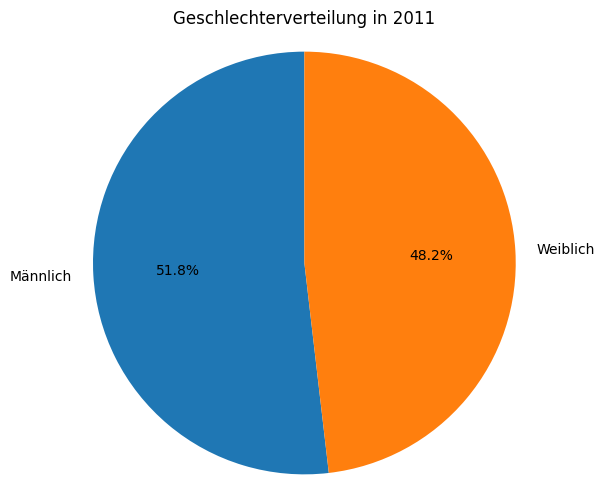

In [86]:
# Plot gender distribution
if not gender_counts.empty:
    plt.figure(figsize=(6, 6))
    plt.pie(gender_counts, labels=['Männlich', 'Weiblich'], autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Geschlechterverteilung in 2011')
    plt.show()
else:
    print("No data found for the specified pattern.")

### Anzahl von Lebendgeborenen in Wien seit 2010

Die zweite Aufbereitung zeigt die Anzahl der Lebendgeborenen in Wien seit 2010 für drei bestimmte Vornamen.

Die Suchanfrage ist eine bool'sche Abfrage, die das Wohnbezirksfeld "C-WOHNBEZIRK-0" auf "900" (Wien) und mindestens einen der Vornamen "Katharina", "Lukas" oder "Thomas" im Feld "F-VORNAME" abgleicht. Die Anzahl der zu findenden Vornamen wird durch "minimum_should_match" auf "1" gesetzt.

Mithilfe der zuvor definierten Funktion "es_to_dataframe(es, index, query, source_fields=None)" wird die Suchanfrage auf Elasticsearch ausgeführt und das Ergebnis als Pandas DataFrame in der Variablen "df2" gespeichert.

Anschließend werden die Ergebnisse für jeden der drei Vornamen separat aus dem DataFrame gefiltert und die Anzahl der Geburten für jeden Vornamen berechnet und ausgegeben.

Schließlich wird eine Balkendiagramm erstellt, das die Anzahl der Geburten für jeden Vornamen darstellt. Wenn keine Daten gefunden wurden, wird eine Meldung ausgegeben.

In [88]:
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-WOHNBEZIRK-0": 900}}
            ],
            "should": [
                {"match": {"F-VORNAME": "Katharina"}},
                {"match": {"F-VORNAME": "Lukas"}},
                {"match": {"F-VORNAME": "Thomas"}}
            ],
            "minimum_should_match": 1
        }
    }
}

source_fields = [
    "C-WOHNBEZIRK-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df2 = es_to_dataframe(es, es_index, query, source_fields)

In [89]:
location = 900

name = "Katharina"
filtered_data_katharina = df2[(df2["F-VORNAME"] == name) & (df2["C-WOHNBEZIRK-0"] == location)]
katharina_count = filtered_data_katharina["F-ANZAHL_LGEB"].sum()
print(katharina_count)

name = "Lukas"
filtered_data_lukas = df2[(df2["F-VORNAME"] == name) & (df2["C-WOHNBEZIRK-0"] == location)]
lukas_count = filtered_data_lukas["F-ANZAHL_LGEB"].sum()
print(lukas_count)

name = "Thomas"
filtered_data_thomas = df2[(df2["F-VORNAME"] == name) & (df2["C-WOHNBEZIRK-0"] == location)]
thomas_count = filtered_data_thomas["F-ANZAHL_LGEB"].sum()
print(thomas_count)

878
2762
264


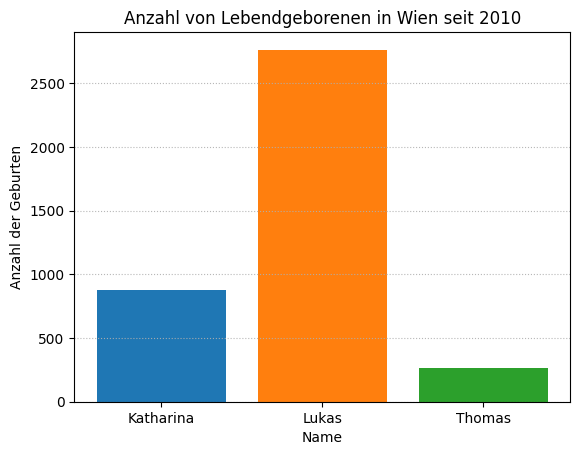

In [94]:
# Create a bar plot
if katharina_count and lukas_count and thomas_count:
    plt.bar(["Katharina"], [katharina_count])
    plt.bar(["Lukas"], [lukas_count])
    plt.bar(["Thomas"], [thomas_count])
    plt.xlabel("Name")
    plt.ylabel("Anzahl der Geburten")
    plt.title(f"Anzahl von Lebendgeborenen in Wien seit 2010")
    plt.grid(axis='y', linestyle=':', alpha=0.9)
    plt.show()
else:
    print("No data found for the specified pattern.")

### Anzahl von weiblichen Lebendgeborenen seit 2010

Nun wurde die Anzahl der weiblichen Lebendgeborenen seit 2010 ermittelt. 

Die Suchanfrage ist eine bool'sche Abfrage, die das Geschlechtsfeld "C-GESCHLECHT-0" auf "2" setzt, um nur weibliche Lebendgeborene zurückzugeben. 

Mithilfe der zuvor definierten Funktion "es_to_dataframe(es, index, query, source_fields=None)" wird die Suchanfrage auf Elasticsearch ausgeführt und das Ergebnis als Pandas DataFrame in der Variablen "df3" gespeichert. 

Die Ergebnisse werden nach Vornamen gruppiert und die Anzahl der Geburten für jeden Vornamen berechnet und in absteigender Reihenfolge ausgegeben. Anschließend werden die Ergebnisse für fünf bestimmte Vornamen separat aus dem DataFrame gefiltert und die Anzahl der Geburten für jeden Vornamen berechnet und ausgegeben.

Schließlich wird eine Balkendiagramm erstellt, das die Anzahl der Geburten für jeden Vornamen darstellt. Wenn keine Daten gefunden wurden, wird eine Meldung ausgegeben.

In [95]:
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-GESCHLECHT-0": 2}}
            ]
        }
    }
}

source_fields = [
    "C-WOHNBEZIRK-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df3 = es_to_dataframe(es, es_index, query, source_fields)

In [96]:
top_names = df3.groupby('F-VORNAME')['F-ANZAHL_LGEB'].sum()
sorted_names = top_names.sort_values(ascending=False)
print(sorted_names)

F-VORNAME
Anna           24666
Sophie         16134
Marie          14621
Emilia         12818
Elena          11195
               ...  
Luiza-Maria        1
Luja               1
Luna-Mae           1
Lykka              1
Živana             1
Name: F-ANZAHL_LGEB, Length: 8244, dtype: int64


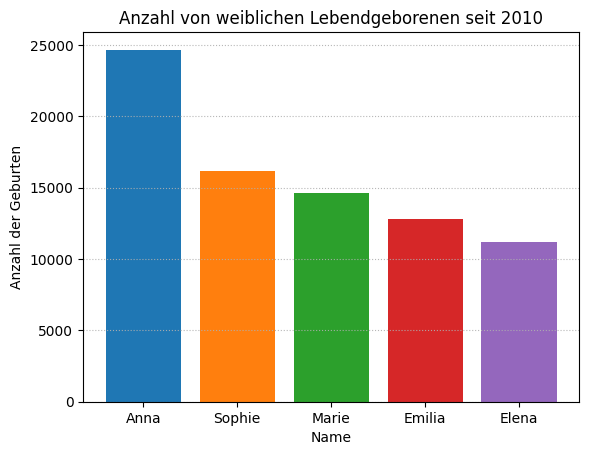

In [97]:
name = "Anna"
filtered_data_anna = df3[(df3["F-VORNAME"] == name)]
anna_count = filtered_data_anna["F-ANZAHL_LGEB"].sum()

name = "Sophie"
filtered_data_sophie = df3[(df3["F-VORNAME"] == name)]
sophie_count = filtered_data_sophie["F-ANZAHL_LGEB"].sum()

name = "Marie"
filtered_data_marie = df3[(df3["F-VORNAME"] == name)]
marie_count = filtered_data_marie["F-ANZAHL_LGEB"].sum()

name = "Emilia"
filtered_data_emilia = df3[(df3["F-VORNAME"] == name)]
emilia_count = filtered_data_emilia["F-ANZAHL_LGEB"].sum()

name = "Elena"
filtered_data_elena = df3[(df3["F-VORNAME"] == name)]
elena_count = filtered_data_elena["F-ANZAHL_LGEB"].sum()

# Create a bar plot
if anna_count and sophie_count and marie_count and emilia_count and elena_count:
    plt.bar(["Anna"], [anna_count])
    plt.bar(["Sophie"], [sophie_count])
    plt.bar(["Marie"], [marie_count])
    plt.bar(["Emilia"], [emilia_count])
    plt.bar(["Elena"], [elena_count])
    plt.xlabel("Name")
    plt.ylabel("Anzahl der Geburten")
    plt.title(f"Anzahl von weiblichen Lebendgeborenen seit 2010")
    plt.grid(axis='y', linestyle=':', alpha=0.9)
    plt.show()
else:
    print("No data found for the specified pattern.")

### Anzahl von männlichen Lebendgeborenen seit 2010

Für die Gegenüberstellung der weiblichen Lebendgeborenen seit 2010 wurden die männlichen Lebengeboren seit 2010 auch analysiert.

Die Suchanfrage ist eine bool'sche Abfrage, die das Geschlechtsfeld "C-GESCHLECHT-0" auf "1" setzt, um nur männliche Lebendgeborene zurückzugeben. 

Mithilfe der zuvor definierten Funktion "es_to_dataframe(es, index, query, source_fields=None)" wird die Suchanfrage auf Elasticsearch ausgeführt und das Ergebnis als Pandas DataFrame in der Variablen "df3" gespeichert. 

Die Ergebnisse werden nach Vornamen gruppiert und die Anzahl der Geburten für jeden Vornamen berechnet und in absteigender Reihenfolge ausgegeben. Anschließend werden die Ergebnisse für fünf bestimmte Vornamen separat aus dem DataFrame gefiltert und die Anzahl der Geburten für jeden Vornamen berechnet und ausgegeben.

Schließlich wird eine Balkendiagramm erstellt, das die Anzahl der Geburten für jeden Vornamen darstellt. Wenn keine Daten gefunden wurden, wird eine Meldung ausgegeben.

In [98]:
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-GESCHLECHT-0": 1}}
            ]
        }
    }
}

source_fields = [
    "C-WOHNBEZIRK-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df4 = es_to_dataframe(es, es_index, query, source_fields)

In [99]:
top_names = df4.groupby('F-VORNAME')['F-ANZAHL_LGEB'].sum()
sorted_names = top_names.sort_values(ascending=False)
print(sorted_names)

F-VORNAME
Lukas         17768
David         10785
Elias         10758
Jakob         10585
Maximilian    10206
              ...  
Si                1
Evian             1
Kiron             1
Shpreson          1
Sarjo             1
Name: F-ANZAHL_LGEB, Length: 7680, dtype: int64


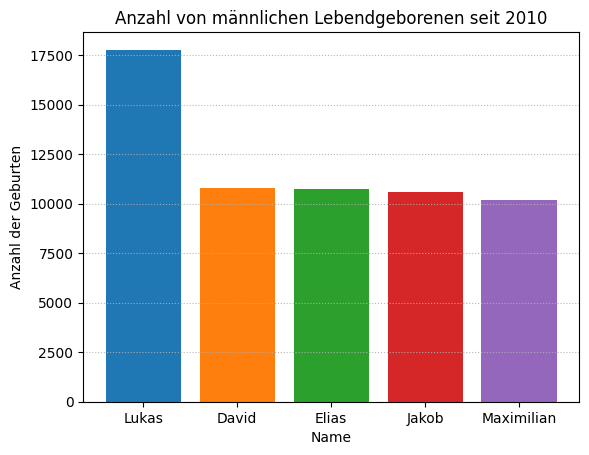

In [100]:
name = "Lukas"
filtered_data_lukas = df4[(df4["F-VORNAME"] == name)]
lukas_count = filtered_data_lukas["F-ANZAHL_LGEB"].sum()

name = "David"
filtered_data_david = df4[(df4["F-VORNAME"] == name)]
david_count = filtered_data_david["F-ANZAHL_LGEB"].sum()

name = "Elias"
filtered_data_elias = df4[(df4["F-VORNAME"] == name)]
elias_count = filtered_data_elias["F-ANZAHL_LGEB"].sum()

name = "Jakob"
filtered_data_jakob = df4[(df4["F-VORNAME"] == name)]
jakob_count = filtered_data_jakob["F-ANZAHL_LGEB"].sum()

name = "Maximilian"
filtered_data_maximilian = df4[(df4["F-VORNAME"] == name)]
maximilian_count = filtered_data_maximilian["F-ANZAHL_LGEB"].sum()

# Create a bar plot
if lukas_count and david_count and elias_count and jakob_count and maximilian_count:
    plt.bar(["Lukas"], [lukas_count])
    plt.bar(["David"], [david_count])
    plt.bar(["Elias"], [elias_count])
    plt.bar(["Jakob"], [jakob_count])
    plt.bar(["Maximilian"], [maximilian_count])
    plt.xlabel("Name")
    plt.ylabel("Anzahl der Geburten")
    plt.title(f"Anzahl von männlichen Lebendgeborenen seit 2010")
    plt.grid(axis='y', linestyle=':', alpha=0.9)
    plt.show()
else:
    print("No data found for the specified pattern.")

### Lebendgeborene vs Bevölkerungszählung in 2011 (rel.)

Die Anzahl von Lebendgeburten im Jahr 2011 im Verhältnis zur Bevölkerungszählung desselben Jahres. Dabei wird ein gestapeltes Balkendiagramm erstellt, das die relative Anzahl von Lebendgeburten und der Bevölkerungsanzahl pro Summe zeigt.

In [101]:
# Dataframe 5 for C-JAHR-0
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-JAHR-0": 2011}}
            ]
        }
    }
}

source_fields = [
    "C-JAHR-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df5 = es_to_dataframe(es, es_index, query, source_fields)

In [102]:
# Dataframe 6 for C-H88-0
lgeb_count = df5["F-ANZAHL_LGEB"].sum()

query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-H88-0": "2011"}}
            ]
        }
    }
}

source_fields = [
    "C-H88-0",
    "F-ISIS-1",
    "C-GRGEM",
]

df6 = es_to_dataframe(es, es_index, query, source_fields)

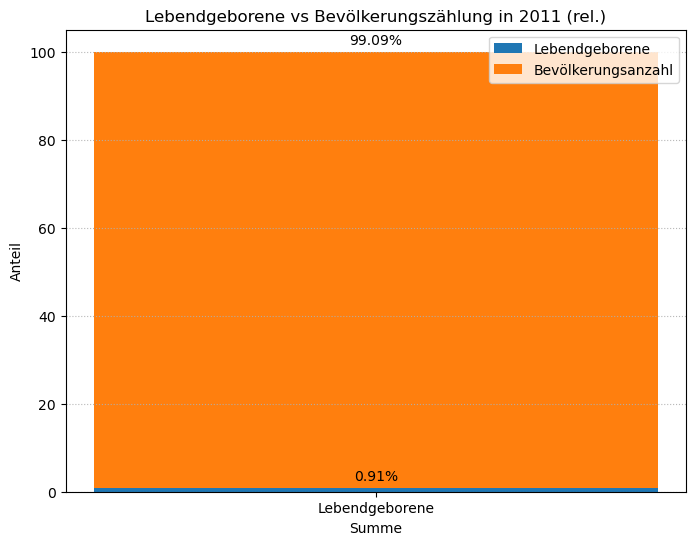

In [367]:
# Create a bar plot
if df5 and df6:
    # Ensure C-WOHNBEZIRK-0 has one characters by padding with zeros
    population_2011 = df6.loc[df6['C-GRGEM'].astype(str).str.len() == 1]
    population_2011_summary = population_2011.sum()

    names = ["Lebendgeborene"]
    counts = [lgeb_count]
    total_population = population_2011_summary['F-ISIS-1']

    # Calculate percentage
    name_percentage = (np.array(counts) / total_population) * 100
    population_percentage = 100 - name_percentage

    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a stacked bar chart
    bar_width = 0.4
    x = np.arange(len(names))
    bars1 = ax.bar(x, name_percentage, bar_width, label="Lebendgeborene")
    bars2 = ax.bar(x, population_percentage, bar_width, bottom=name_percentage, label="Bevölkerungsanzahl")

    # Add labels, title and custom x-axis tick labels
    ax.set_xlabel("Summe")
    ax.set_ylabel("Anteil")
    ax.set_title("Lebendgeborene vs Bevölkerungszählung in 2011 (rel.)")
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()

    # Annotate the bars with their values
    for bar, pct in zip(bars1, name_percentage):
        height = bar.get_height()
        ax.annotate('{:.2f}%'.format(pct),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    for bar, pct in zip(bars2, population_percentage):
        height = bar.get_height()
        ax.annotate('{:.2f}%'.format(pct),
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
    plt.grid(axis='y', linestyle=':', alpha=0.9)

    plt.show()
else:
    print("No data found for the specified pattern.")

### Die beliebtesten Namen in jedem politischen Bezirk

Der nächste Abschnitt führt eine Analyse & Visualisierung durch, um die beliebtesten Namen in jedem politischen Bezirk im Burgenland seit 2010 zu ermitteln. Zunächst wird eine Suchabfrage auf Elasticsearch ausgeführt, um alle verfügbaren Daten abzurufen. Anschließend wird der Datensatz gruppiert, um die Anzahl der Lebendgeburten pro Name und Bezirk zu ermitteln. 

Die Ergebnisse werden dann gefiltert, um nur die Bezirke im Burgenland zu behalten, und nach der Anzahl der Lebendgeburten sortiert. Schließlich werden die beliebtesten Namen in jedem Bezirk ausgewählt und in einem horizontalen Balkendiagramm visualisiert. Das Diagramm zeigt die Bezirke auf der y-Achse und den beliebtesten Namen auf der x-Achse.

In [25]:
query = {
    "query": {
        "match_all": {}
    }
}

source_fields = [
    "C-H88-0",
    "C-GRGEM",
    "F-ISIS-1",
    "C-JAHR-0",
    "C-WOHNBEZIRK-0",
    "C-GESCHLECHT-0",
    "F-VORNAME",
    "F-VORNAME_NORMALISIERT",
    "F-ANZAHL_LGEB",
]

df7 = es_to_dataframe(es, es_index, query, source_fields)

In [59]:
# Group the data
top_names_by_district = df7.groupby(['C-WOHNBEZIRK-0', 'F-VORNAME_NORMALISIERT'])['F-ANZAHL_LGEB'].sum().reset_index()

# Filter the rows based on the pattern
pattern = r'^1\d{2}\.0$'
filtered_top_names_by_district = top_names_by_district[top_names_by_district['C-WOHNBEZIRK-0'].astype(str).str.match(pattern)]

# Sort and group the filtered data
top_names_by_district_result = filtered_top_names_by_district.sort_values(['C-WOHNBEZIRK-0', 'F-ANZAHL_LGEB'], ascending=[True, False]).groupby('C-WOHNBEZIRK-0').head(1)

# Convert the 'C-WOHNBEZIRK-0' column to integer
top_names_by_district_result['C-WOHNBEZIRK-0'] = top_names_by_district_result['C-WOHNBEZIRK-0'].astype(int)

# Print the DataFrame
print(top_names_by_district_result)


      C-WOHNBEZIRK-0 F-VORNAME_NORMALISIERT  F-ANZAHL_LGEB
400              101             Maximilian           26.0
580              102              Alexander            5.0
1329             103             Maximilian           54.0
1681             104                   Anna           36.0
2605             105                   Paul           23.0
3157             106                  Jonas           47.0
3807             107                   Anna           70.0
4946             108                   Anna           47.0
6582             109                   Paul           68.0


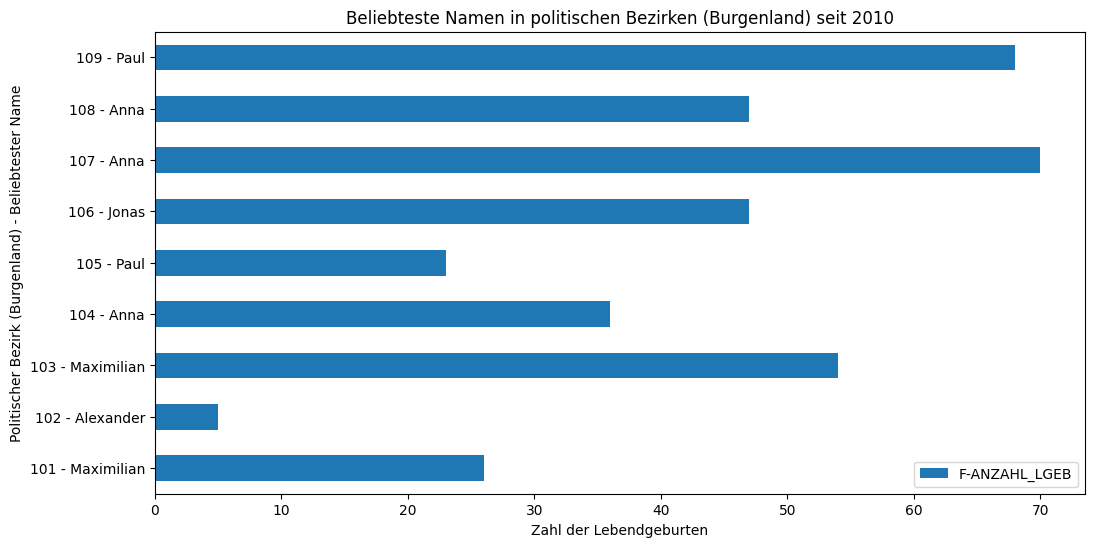

In [64]:
# Add a column that combines the district and most popular name
top_names_by_district_result['district_and_name'] = top_names_by_district_result['C-WOHNBEZIRK-0'].astype(str) + ' - ' + top_names_by_district_result['F-VORNAME_NORMALISIERT']

# Visualization
if not top_names_by_district_result.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_names_by_district_result.plot(kind='barh', x='C-WOHNBEZIRK-0', y='F-ANZAHL_LGEB', ax=ax)
    ax.set_yticklabels(top_names_by_district_result['district_and_name'])
    plt.title('Beliebteste Namen in politischen Bezirken (Burgenland) seit 2010')
    plt.xlabel('Zahl der Lebendgeburten')
    plt.ylabel('Politischer Bezirk (Burgenland) - Beliebtester Name')
    plt.show()
else:
    print("No data found for the specified pattern.")

### Lebendgeburten in den Bezirken von Salzburg (2010-2021)

Im letzten analystischen Code-Abschnitt geht es um die Aufbereitung der Lebendgeburten in den Bezirken von Salzburg von 2010 bis 2021. Zunächst wird eine Elasticsearch-Abfrage erstellt, um alle relevanten Daten abzurufen. Dann werden die Daten gefiltert, um nur diejenigen Bezirke zu erhalten, deren Bezirkscode mit '5' beginnen und genau drei Zeichen haben.

Die Daten werden dann nach Jahr gruppiert und die Summe der Lebendgeburten berechnet. Die resultierenden Daten werden in einem DataFrame gespeichert und anschließend visualisiert. Die Visualisierung zeigt die Anzahl der Lebendgeburten in jedem Jahr von 2010 bis 2021 auf der Y-Achse und das Jahr auf der X-Achse. Es wird auch eine Beschriftung hinzugefügt, die die Anzahl der Lebendgeburten jedes Jahr angibt.

In [68]:
query = {
    "query": {
        "match_all": {}
    }
}

source_fields = [
    "C-H88-0",
    "C-GRGEM",
    "F-ISIS-1",
    "C-JAHR-0",
    "C-WOHNBEZIRK-0",
    "C-GESCHLECHT-0",
    "F-VORNAME",
    "F-VORNAME_NORMALISIERT",
    "F-ANZAHL_LGEB",
]

df8 = es_to_dataframe(es, es_index, query, source_fields)

In [79]:
# Filter rows where the district starts with '5' and has exactly 3 characters
pattern = r'^5\d{2}\.0$'
districts_5xx_data = df8[df8['C-WOHNBEZIRK-0'].astype(str).str.match(pattern)]

# Group data by year and calculate the sum of live births
live_births_districts_5xx = districts_5xx_data.groupby('C-JAHR-0')['F-ANZAHL_LGEB'].sum().reset_index()

# Convert the 'C-JAHR-0' column to integer
live_births_districts_5xx['C-JAHR-0'] = live_births_districts_5xx['C-JAHR-0'].astype(int)

# Convert the 'C-ANZAHL_LGEB' column to integer
live_births_districts_5xx['F-ANZAHL_LGEB'] = live_births_districts_5xx['F-ANZAHL_LGEB'].astype(int)

# Print the DataFrame
print(live_births_districts_5xx)

    C-JAHR-0  F-ANZAHL_LGEB
0       2010           5009
1       2011           4955
2       2012           4991
3       2013           5088
4       2014           5343
5       2015           5383
6       2016           5537
7       2017           5743
8       2018           5484
9       2019           5650
10      2020           5656
11      2021           5646


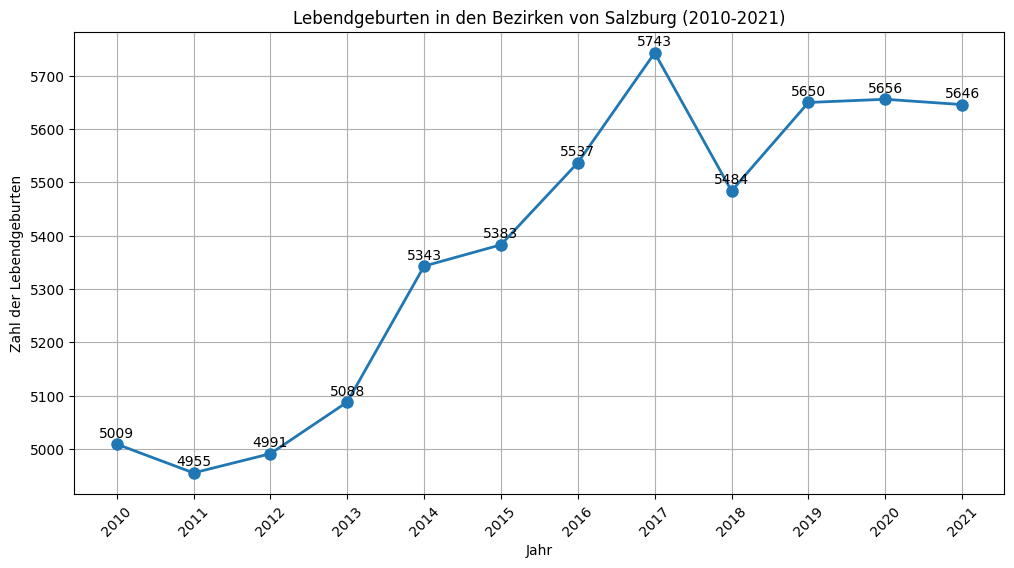

In [81]:
# Visualization
if not live_births_districts_1xx.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(live_births_districts_5xx['C-JAHR-0'], live_births_districts_5xx['F-ANZAHL_LGEB'], marker='o', linestyle='-', linewidth=2, markersize=8)

    plt.title('Lebendgeburten in den Bezirken von Salzburg (2010-2021)')
    plt.xlabel('Jahr')
    plt.ylabel('Zahl der Lebendgeburten')
    plt.xticks(live_births_districts_5xx['C-JAHR-0'], rotation=45)
    ax.grid(True)

    for x, y in zip(live_births_districts_5xx['C-JAHR-0'], live_births_districts_5xx['F-ANZAHL_LGEB']):
        label = f"{y:.0f}"
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)

    plt.show()
else:
    print("No data found for the specified pattern.")

### Index löschen

Dieser Einzeiler löscht den Elasticsearch-Index mit dem Namen "idx1" und wurde wegen Testzwecke im Notebook behalten.

Zunächst wird die Methode es.options() aufgerufen, um eine Konfiguration für die Anfrage zu setzen, damit HTTP-Statuscodes 400 und 404 ignoriert werden. Wenn der Index bereits gelöscht wurde oder nicht existiert, gibt Elasticsearch normalerweise einen 404-Fehler zurück, den wir hier ignorieren möchten.

Dann wird die delete()-Methode aufgerufen, um den Index zu löschen. Das Argument "index" wird verwendet, um den Namen des zu löschenden Index anzugeben.

In [ ]:
# es.options(ignore_status=[400,404]).indices.delete(index='idx1')

Die vorgestellten Codeabschnitte zeigen einige Möglichkeiten, wie man Daten von einem Elasticsearch-Index abfragen und visualisieren kann. Insbesondere lassen sich aus den Daten interessante Erkenntnisse gewinnen, wie beispielsweise die beliebtesten Namen in den politischen Bezirken von Burgenland oder die Entwicklung der Lebendgeburten in den Bezirken von Salzburg über die Jahre hinweg.

Die Verwendung von Elasticsearch in Kombination mit Python bietet eine leistungsstarke und flexible Methode, um große Datenmengen zu durchsuchen, zu filtern und zu analysieren. Es ermöglicht auch die Erstellung von dynamischen Visualisierungen, die eine schnelle und einfache Interpretation der Daten ermöglichen.

Insgesamt können die vorgestellten Methoden für eine Vielzahl von Anwendungsfällen nützlich sein, insbesondere für die Analyse und Visualisierung von Daten, die in einem Elasticsearch-Index gespeichert sind.